In [1]:
import torch
import seaborn as sns
from pyro.distributions import transforms as T
import pyro.distributions as dist
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd

In [2]:
dataset = torch.cat([torch.randn(64), torch.randn(8) + 6])[:, None]

dataset = np.load('../datasets/Combined_GWTC_m1m2chieffz.npz')
dataset = torch.from_numpy(dataset['m1']).float()
# dataset= dataset.log()
# dataset = dataset.mean(1, keepdim=True)
dataset = (dataset - dataset.mean()) / dataset.std()





<AxesSubplot:ylabel='Count'>

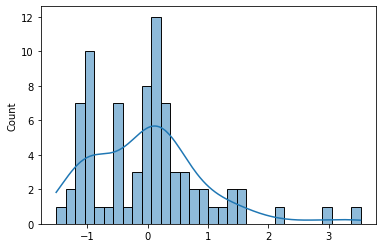

In [3]:
sns.histplot(dataset.mean(1), kde=True, bins=32)


<AxesSubplot:ylabel='Density'>

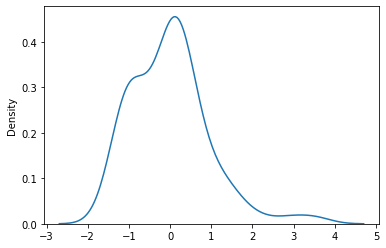

In [4]:
sns.kdeplot(dataset.mean(1).squeeze())

In [5]:
d = 1
n_layers = 6

<AxesSubplot:>

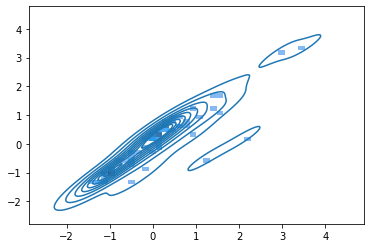

In [6]:
# dataset_2d = torch.cat([torch.randn(64), torch.randn(8) + 6])
# dataset_2d = torch.stack([dataset_2d, dataset_2d + torch.randn_like(dataset_2d)], dim=-1)

dataset = np.load('../datasets/Combined_GWTC_m1m2chieffz.npz')
dataset_2d = torch.stack([torch.tensor(dataset['m1']), torch.tensor(dataset['m2'])], dim=-1).float()

dataset_2d = (dataset_2d - dataset_2d.mean(dim=(0, 1), keepdim=True)) / dataset_2d.std(dim=(0, 1), keepdim=True)

sns.histplot(x=dataset_2d.mean(1)[:, 0], y=dataset_2d.mean(1)[:, 1], bins=32)
sns.kdeplot(x=dataset_2d.mean(1)[:, 0], y=dataset_2d.mean(1)[:, 1])





step: 0, loss: 3.1291117668151855


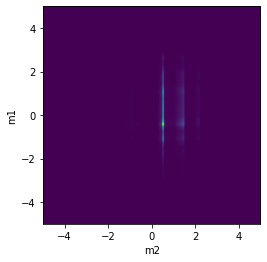

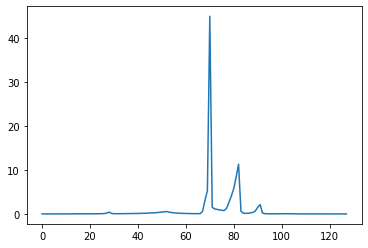

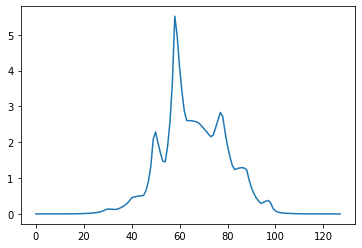

step: 8, loss: 3.1334054470062256


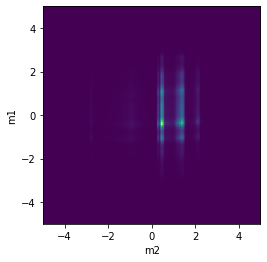

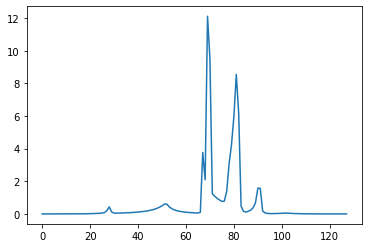

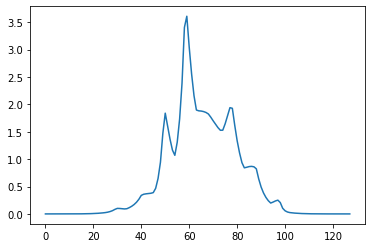

step: 16, loss: 3.417543649673462


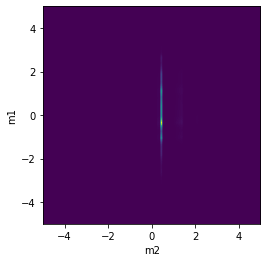

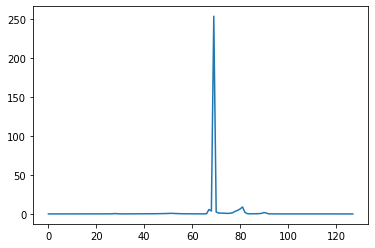

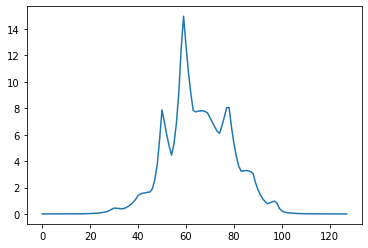

step: 24, loss: 2.704479217529297


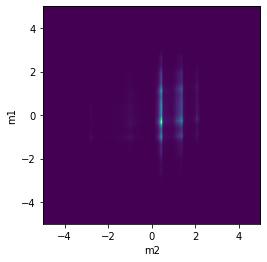

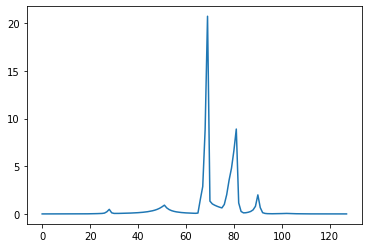

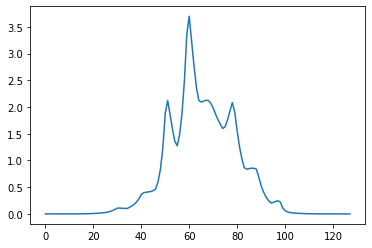

step: 32, loss: 1.3951752185821533


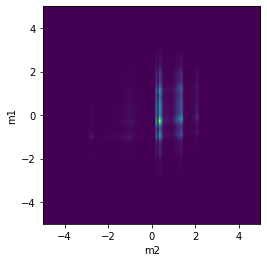

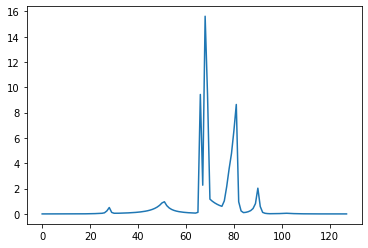

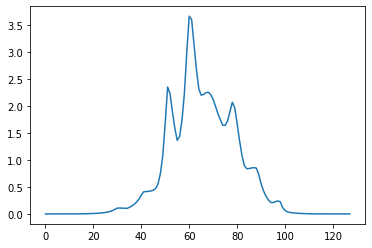

step: 40, loss: 3.081134080886841


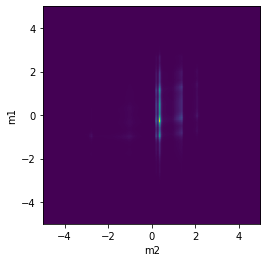

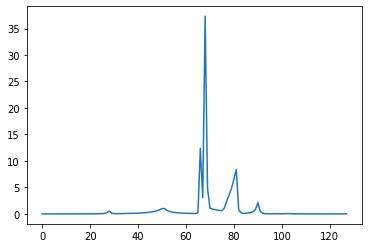

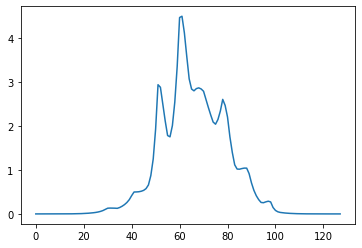

step: 48, loss: 4.544752597808838


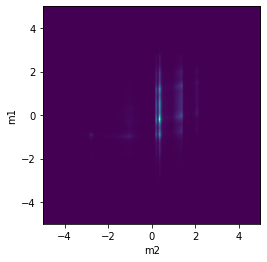

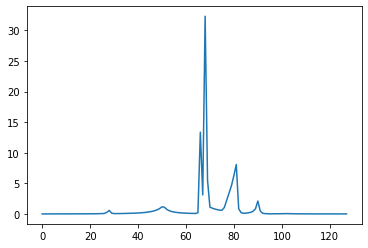

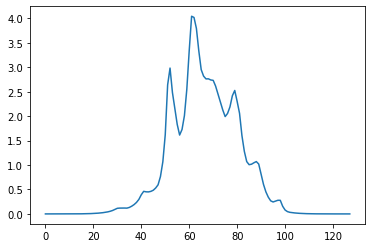

step: 56, loss: 2.6013035774230957


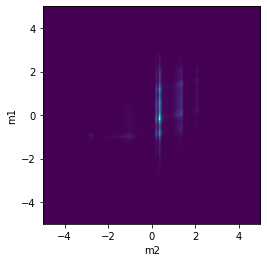

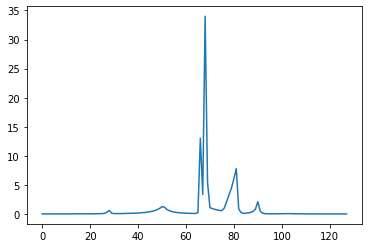

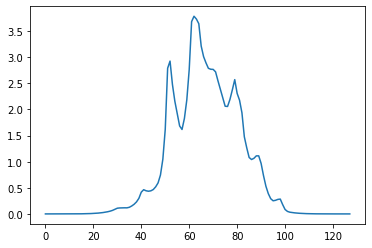

step: 64, loss: 2.7664175033569336


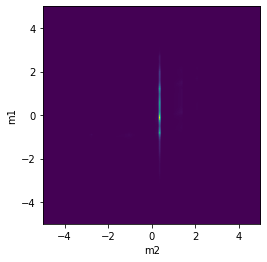

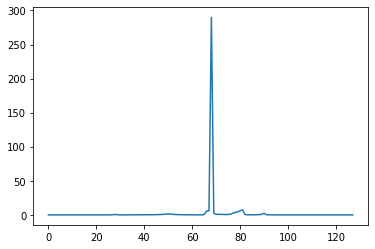

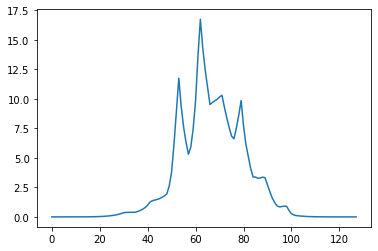

step: 72, loss: 2.283475399017334


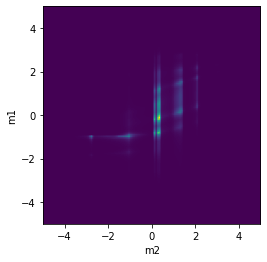

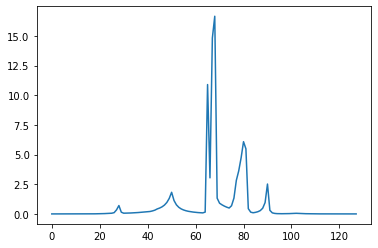

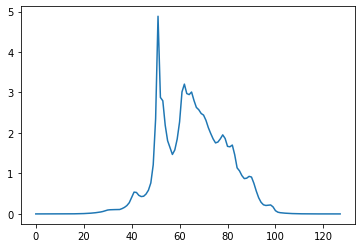

step: 80, loss: 3.544236898422241


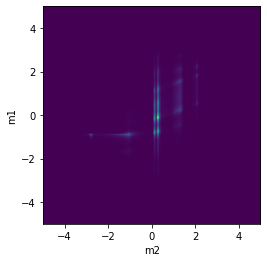

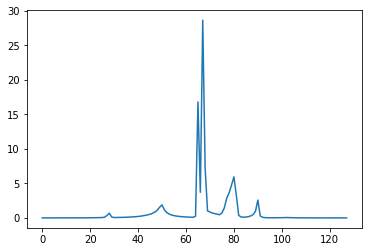

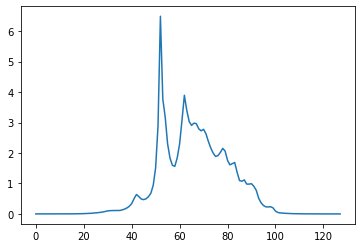

step: 88, loss: 1.332843542098999


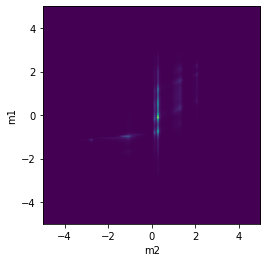

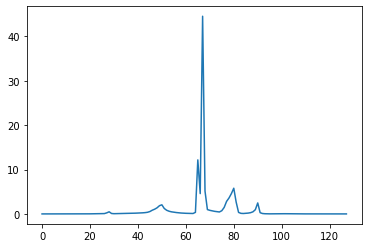

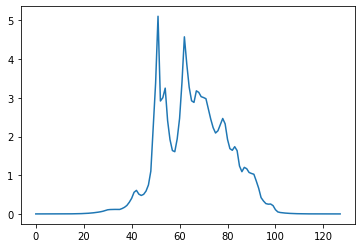

step: 96, loss: 1.5870683193206787


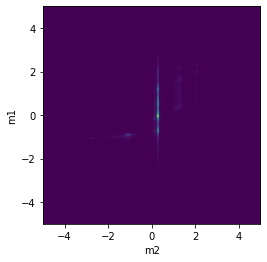

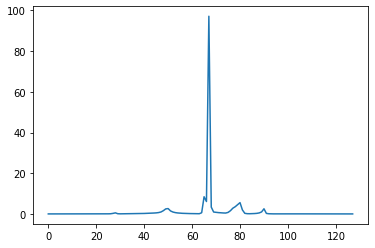

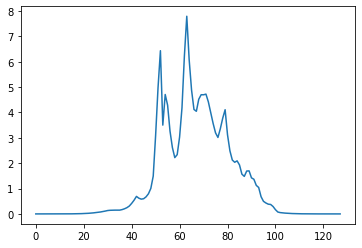

step: 104, loss: 2.8439230918884277


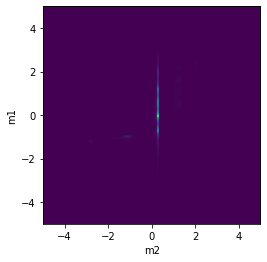

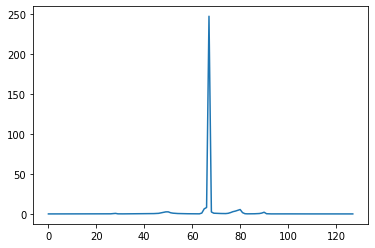

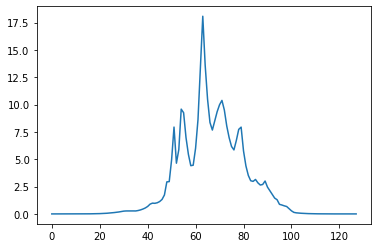

step: 112, loss: 2.5593271255493164


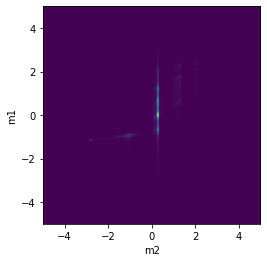

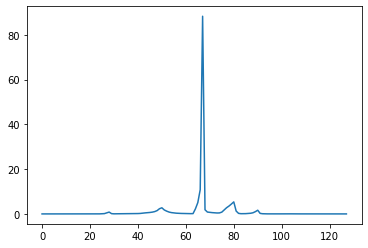

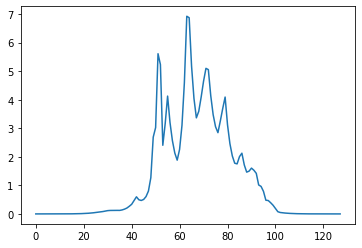

step: 120, loss: 1.511757493019104


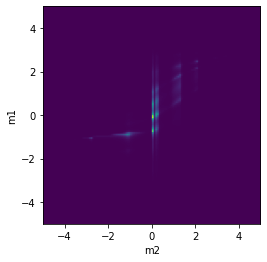

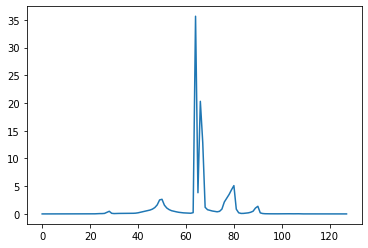

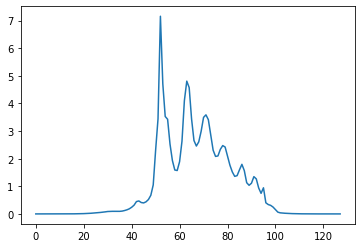

step: 128, loss: 1.552297592163086


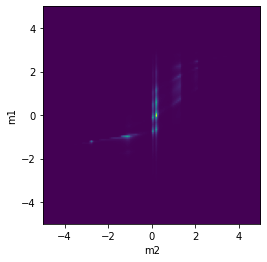

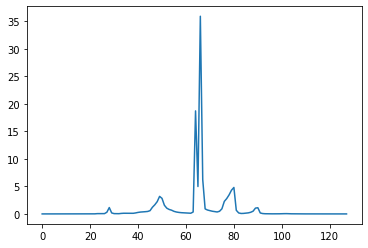

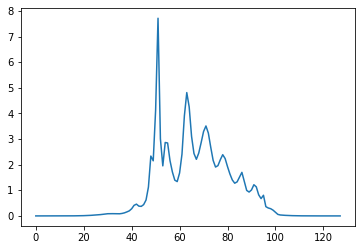

step: 136, loss: 1.779522180557251


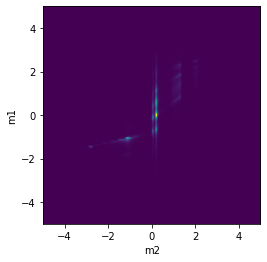

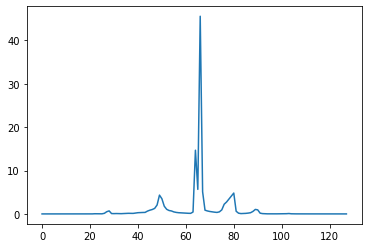

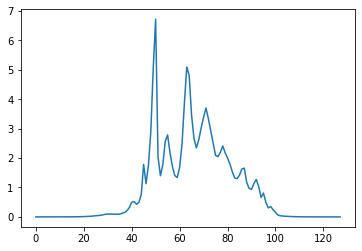

step: 144, loss: 2.7638468742370605


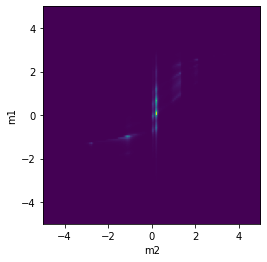

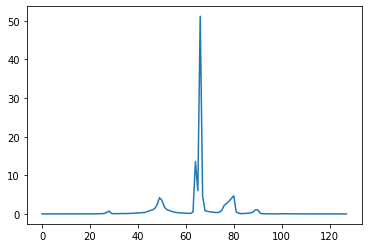

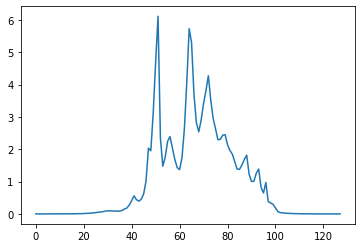

step: 152, loss: 2.0720748901367188


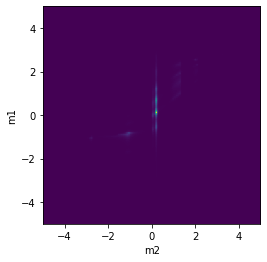

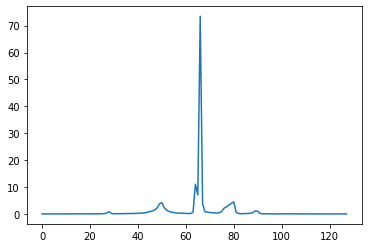

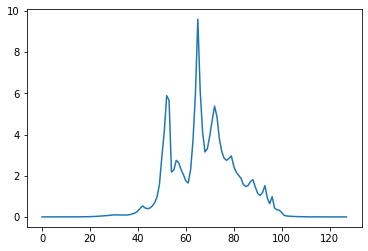

step: 160, loss: 2.8842649459838867


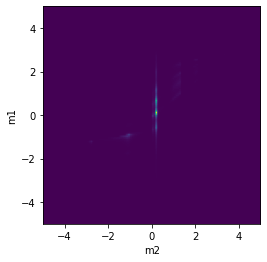

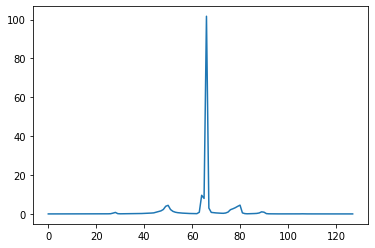

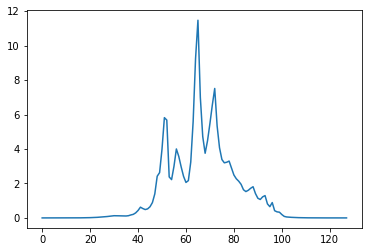

step: 168, loss: 1.7310271263122559


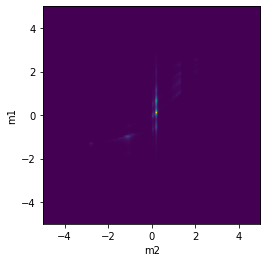

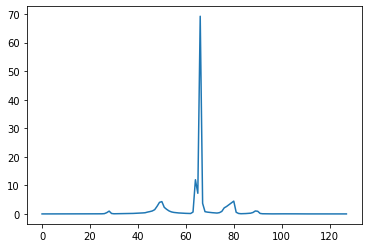

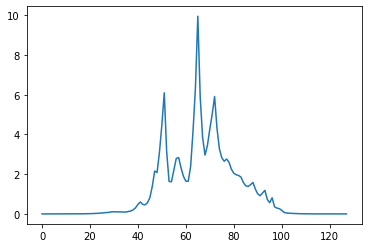

step: 176, loss: 2.645691394805908


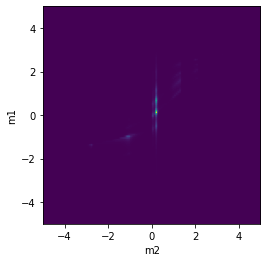

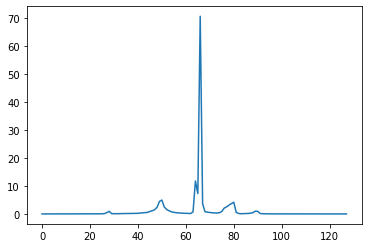

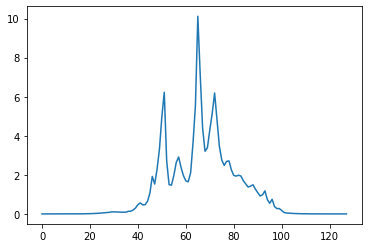

step: 184, loss: 2.4608535766601562


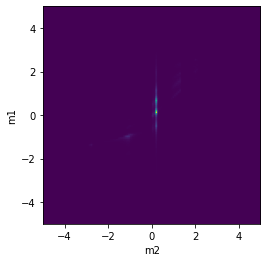

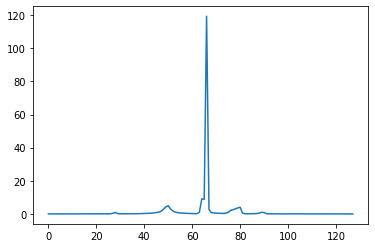

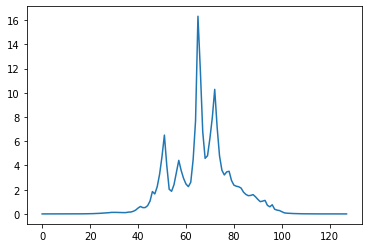

KeyboardInterrupt: 

In [9]:

d = 2
n_layers = 8

# transform_modules = nn.ModuleList([m for m in transforms if isinstance(m, nn.Module)])

transforms_m1 = [T.spline(1)]
transforms_m2 = [T.conditional_spline(1, 1)]

base_dist = dist.Normal(torch.zeros(1), torch.ones(1))
dist_1 = dist.TransformedDistribution(base_dist, transforms_m1)
dist_2 = dist.ConditionalTransformedDistribution(base_dist, transforms_m2)

trainable_modules = [m for m in transforms_m1 + transforms_m2 if isinstance(m, nn.Module)]

def log_prob(x, transforms, base_dist):
    x= x.clone()
    J = 0
    for t in transforms:
        y = t(x)
        J += t.log_abs_det_jacobian(x, y)
        x = y
        
    log_prob = base_dist.log_prob(x).sum(-1) + J.sum(-1)
    return log_prob, y

batch_size = 4
steps = 8192
optimizer = torch.optim.Adam(nn.ModuleList(trainable_modules).parameters(), lr=3e-3)
for step in range(steps+1):
    optimizer.zero_grad()
    
    batch = dataset_2d[torch.randperm(len(dataset_2d))][:batch_size]
#     print(dataset_2d.shape)
#     lp, y = log_prob(batch, transforms, base_dist)
    batch_m1 = batch[..., :1]
    batch_m1_flat = batch_m1.view(-1, 1)
    lp_1, y_1 = log_prob(batch_m1_flat, dist_1.transforms, base_dist)
    lp_1 = lp_1.view(batch_m1.shape[:-1])
    batch_m2 = batch[..., 1:2]
    batch_m2_flat = batch_m2.view(-1, 1)

    lp_2, y_2 = log_prob(batch_m2_flat, dist_2.condition(batch_m1_flat.detach()).transforms, base_dist)
    lp_2 = lp_2.view(batch_m2.shape[:-1])
    
    lp = torch.logsumexp(lp_1 + lp_2, dim=-1) - math.log(lp_1.shape[-1])    

    loss = -lp.mean()
#     loss = -log_prob(flow_dist, dataset_2d).mean()
    loss.backward()
    optimizer.step()
    
    
    
    if step % 8 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))
        with torch.no_grad():
            x = torch.linspace(-5, 5, 128)
            xx, yy = torch.meshgrid(x, x, indexing='xy')
#             grid = torch.stack([xx, yy]).view(d, -1).permute(1, 0)
            lp_1, y_1 = log_prob(xx.reshape(-1, 1), dist_1.transforms, base_dist)
            lp_2, y_2 = log_prob(yy.reshape(-1, 1), dist_2.condition(xx.reshape(-1, 1)).transforms, base_dist)
            
            lp = lp_1 + lp_2
            
            p = lp.exp().view(128, 128)
            
#             p[range(128), range(128)] = p.max()
            plt.imshow(p, extent=(-5, 5, -5, 5), origin='lower')
            plt.ylabel('m1')
            plt.xlabel('m2')
            plt.show()
#             data = pd.DataFrame(data={'x':xx.flatten().numpy().round(2), 'y':yy.flatten().numpy().round(2), 'z':p.numpy()})
#             data = data.pivot(index='x', columns='y', values='z')
#             sns.heatmap(data)
#             plt.show()
            
            plt.plot(p.sum(0))
            plt.show()
            plt.plot(p.sum(1))
            plt.show()




In [ ]:
# dataset_2d = torch.cat([torch.randn(64), torch.randn(8) + 6])
# dataset_2d = torch.stack([dataset_2d, dataset_2d + torch.randn_like(dataset_2d)], dim=-1)

dataset = np.load('../datasets/Combined_GWTC_m1m2chieffz.npz')
q = dataset['m1'] - dataset['m2']
dataset_2d = torch.stack([torch.tensor(dataset['m1']), torch.tensor(q)], dim=-1).float()

dataset_2d = (dataset_2d - dataset_2d.mean(dim=(0, 1), keepdim=True)) / dataset_2d.std(dim=(0, 1), keepdim=True)

sns.histplot(x=dataset_2d.mean(1)[:, 0], y=dataset_2d.mean(1)[:, 1], bins=32)
sns.kdeplot(x=dataset_2d.mean(1)[:, 0], y=dataset_2d.mean(1)[:, 1])





In [ ]:

d = 2
n_layers = 8

transforms = []
for _ in range(n_layers):
    transforms.append(T.planar(d))
    transforms.append(T.permute(d, permutation=torch.tensor([1, 0])))
transform_modules = nn.ModuleList([m for m in transforms if isinstance(m, nn.Module)])

base_dist = dist.Normal(0, 1)

def log_prob(x, transforms, base_dist):
    x= x.clone()
    J = 0
    for t in transforms:
#         print(x.shape)
        y = t(x)
        J += t.log_abs_det_jacobian(x, y)
        x = y
        
    log_prob = base_dist.log_prob(x).sum(-1) + J
    return log_prob, y

batch_size = 4
steps = 8192
optimizer = torch.optim.Adam(transform_modules.parameters(), lr=1e-2)
for step in range(steps+1):
    optimizer.zero_grad()
    
    batch = dataset_2d[torch.randperm(len(dataset_2d))][:batch_size]
#     print(dataset_2d.shape)
#     lp, y = log_prob(batch, transforms, base_dist)
    lp, y = log_prob(batch.view(-1, 2), transforms, base_dist)
    lp = lp.view(batch.shape[:-1])
    
    lp = torch.logsumexp(lp, dim=-1) - math.log(lp.shape[-1])    

    loss = -lp.mean()
#     loss = -log_prob(flow_dist, dataset_2d).mean()
    loss.backward()
    optimizer.step()
    
    
    
    if step % 8 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))
        with torch.no_grad():
            x = torch.linspace(-5, 5, 128)
            xx, yy = torch.meshgrid(x, x, indexing='xy')
            grid = torch.stack([xx, yy]).view(d, -1).permute(1, 0)
            lp, y = log_prob(grid, transforms, base_dist)
            p = lp.exp().view(128, 128)
#             p[range(128), range(128)] = p.max()
            plt.imshow(p, extent=(-5, 5, -5, 5), origin='lower')
            plt.ylabel('m1')
            plt.xlabel('q')
            plt.show()
#             data = pd.DataFrame(data={'x':xx.flatten().numpy().round(2), 'y':yy.flatten().numpy().round(2), 'z':p.numpy()})
#             data = data.pivot(index='x', columns='y', values='z')
#             sns.heatmap(data)
#             plt.show()
            
            plt.plot(p.sum(0))
            plt.show()
            plt.plot(p.sum(1))
            plt.show()


